In [20]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated,Literal
from IPython.display import display, Image
import operator
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()
from pydantic import BaseModel, Field


In [21]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [22]:
class QuestionCategory(BaseModel):
    department: Literal["HR", "Tech Support"]
    issue_summary: str = Field(description="A brief summary of the user's issue or query")

In [23]:
# class HR_Response_Schema(BaseModel):
#     hr_query_category: Literal["Leave Policy", "Payroll", "Recruitment", "Compliance", "Other"] = Field(
#         description="Specific HR-related category of the user query"
#     )

In [24]:
# class Tech_Response_Schema(BaseModel):
#     tech_query_category: Literal["Infrastructure", "Software Bug", "DevOps", "Data", "Other"] = Field(
#         description="Specific technical category of the user query"
#     )
#     urgency: Literal["low", "medium", "high"] = Field(
#         description="How urgent the technical query appears to be"
#     )
#     complexity: Literal["simple", "moderate", "complexx"] = Field(
#         description="Estimated complexity of resolving the technical query"
#     )

In [25]:
structured_model = model.with_structured_output(QuestionCategory) 
# structured_model_hr = model.with_structured_output(HR_Response_Schema)
# structured_model_tech  = model.with_structured_output(Tech_Response_Schema)

In [26]:
# user_query = "In my project, the deployment pipeline is failing during the build stage. Can you help? because I have an urgent deadline."
# result = structured_model_dept_class.invoke(user_query)
# result

In [27]:
class QuerysolverState(TypedDict):
    query_summary: str
    query: str
    department: Literal["HR", "Tech Support"]
    response: str

In [28]:
graph =StateGraph(QuerysolverState)

In [29]:
def find_department(state:QuerysolverState):
    prompt = f'For the following Query find out the Department \n {state["query"]} \n Respond in the format: \n Department: <HR or Tech Support> \n Issue Summary: <A brief summary of the user\'s issue or query>'
    department = structured_model.invoke(prompt).department

    return {"department":department}


In [30]:
def check_department(state:QuerysolverState)-> Literal["hr_response","tech_response"]:
    if state["department"] == "HR":
        return "hr_response"
    else:
        return "tech_response"

In [31]:
def hr_response(state:QuerysolverState):
    prompt = f'You are an HR assistant. Provide a concise and professional response to the following HR query: {state["query"]}'
    response = model.invoke(prompt)
    return {"response":response}
    

In [32]:
def tech_response(state:QuerysolverState):
    prompt = f'You are a Tech Support assistant. Provide a concise and professional response to the following technical query: {state["query"]}'
    response = model.invoke(prompt)
    return {"response":response}

In [33]:
# nodes
graph.add_node("find_department",find_department)
graph.add_node("hr_response",hr_response)

graph.add_node("tech_response",tech_response)

# Edges
graph.add_edge(START,"find_department")
graph.add_conditional_edges("find_department",check_department)
graph.add_edge("hr_response",END)
graph.add_edge("tech_response",END)



In [34]:
workflow = graph.compile()
# display(Image(workflow.get_graph().draw_mermaid_png()))

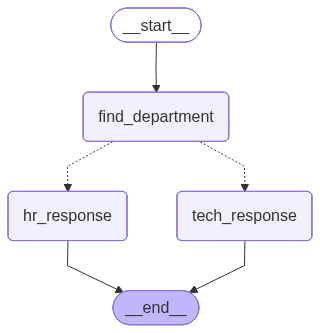

In [39]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [36]:
initial_state = {"query": "I want to know about the policies for taking leaves.and how many leaves do I have left this year?", "query_summary":""}
result = workflow.invoke(initial_state)
result

{'query_summary': '',
 'query': 'I want to know about the policies for taking leaves.and how many leaves do I have left this year?',
 'department': 'HR',
 'response': AIMessage(content="Hello!\n\nOur comprehensive leave policies, including details on vacation, sick, personal, and other types of leave, are fully outlined in the **Employee Handbook** and accessible on our **HR Portal**. These resources provide information on eligibility, request procedures, and guidelines. Please let me know if you have specific questions after reviewing them.\n\nRegarding your remaining leave balance for this year, you can easily check this information directly through our **HRIS system (e.g., Workday, ADP, BambooHR)**. If you encounter any issues accessing your balance or need assistance, please don't hesitate to reach out, and I'd be happy to help you look it up.\n\nBest regards,\n\n[Your Name/HR Department]", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_rati

In [38]:
result["response"].content

"Hello!\n\nOur comprehensive leave policies, including details on vacation, sick, personal, and other types of leave, are fully outlined in the **Employee Handbook** and accessible on our **HR Portal**. These resources provide information on eligibility, request procedures, and guidelines. Please let me know if you have specific questions after reviewing them.\n\nRegarding your remaining leave balance for this year, you can easily check this information directly through our **HRIS system (e.g., Workday, ADP, BambooHR)**. If you encounter any issues accessing your balance or need assistance, please don't hesitate to reach out, and I'd be happy to help you look it up.\n\nBest regards,\n\n[Your Name/HR Department]"